# 介紹  
本專案爬取股市資料，並使用LSTM及RNN對股價進行預測



## 爬股市資料

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.models import Sequential

In [ ]:
df = yf.Ticker("2330.TW").history(period="2y") #台積
df  # 先看看資料結構
# 也可以指定期間資料: df = yf.download("2330.TW", start='2024-05-01', end='2024-05-20')

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-05-30 00:00:00+08:00,515.664415,524.290771,514.705931,524.290771,34476433,0.0,0.0
2022-05-31 00:00:00+08:00,519.498385,536.751099,517.581417,536.751099,72405873,0.0,0.0
2022-06-01 00:00:00+08:00,527.166309,531.958730,525.249341,526.207825,29155176,0.0,0.0
2022-06-02 00:00:00+08:00,521.415419,522.373903,517.581482,517.581482,21420890,0.0,0.0
2022-06-06 00:00:00+08:00,518.539966,521.415419,515.664513,517.581482,17615003,0.0,0.0
...,...,...,...,...,...,...,...
2024-05-23 00:00:00+08:00,875.000000,877.000000,867.000000,875.000000,37266618,0.0,0.0
2024-05-24 00:00:00+08:00,858.000000,872.000000,858.000000,867.000000,34136382,0.0,0.0
2024-05-27 00:00:00+08:00,872.000000,878.000000,866.000000,869.000000,26726954,0.0,0.0


擷取所需資料(收盤價)

In [ ]:
df = df.filter(["Close"])
df

,Close
Date,
2022-05-30 00:00:00+08:00,524.290771
2022-05-31 00:00:00+08:00,536.751099
2022-06-01 00:00:00+08:00,526.207825
2022-06-02 00:00:00+08:00,517.581482
2022-06-06 00:00:00+08:00,517.581482
...,...
2024-05-23 00:00:00+08:00,875.000000
2024-05-24 00:00:00+08:00,867.000000
2024-05-27 00:00:00+08:00,869.000000


資料視覺化
繪製K線


<ipython-input-4-59c13bb1430e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid") # 樣式


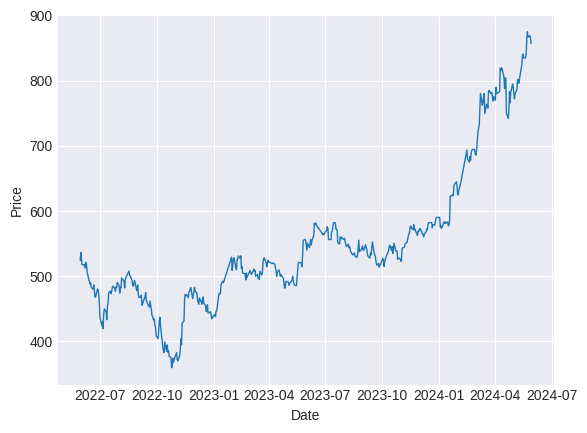

In [ ]:
# 收盤價的日K線
plt.style.use("seaborn-darkgrid") # 樣式
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(df["Close"], linewidth=1)
plt.show()

### 資料標準化

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler_prices = scaler.fit_transform(df.values)
scaler_prices  #把資料正規化到0~1範圍之內

array([[0.31955373],
       [0.34372927],
       [0.3232732 ],
       [0.30653636],
       [0.30653636],
       [0.29723811],
       [0.31397506],
       [0.30839592],
       [0.28793985],
       [0.2619047 ],
       [0.25632574],
       [0.24888716],
       [0.25215923],
       [0.23907087],
       [0.23346159],
       [0.24654989],
       [0.2269175 ],
       [0.21008966],
       [0.21195958],
       [0.23439658],
       [0.23252678],
       [0.22037335],
       [0.19232707],
       [0.15025767],
       [0.12501599],
       [0.13623456],
       [0.11660204],
       [0.15773663],
       [0.17549928],
       [0.16615064],
       [0.14277865],
       [0.18204343],
       [0.19045732],
       [0.22317808],
       [0.2287873 ],
       [0.22037335],
       [0.22785243],
       [0.23907087],
       [0.24281047],
       [0.23626632],
       [0.22785243],
       [0.24094073],
       [0.23907087],
       [0.25402897],
       [0.24468009],
       [0.22224327],
       [0.23907087],
       [0.237

### 建立資料集
取出每一單位天與前60天的收盤價



In [ ]:
MOVING_WIN_SIZE = 60
all_x, all_y = [], []
for i in range(len(scaler_prices)-MOVING_WIN_SIZE):
  x = scaler_prices[i:i+MOVING_WIN_SIZE] # X: 前60天的收盤價
  y = scaler_prices[i+MOVING_WIN_SIZE] # y: 第61天的收盤價
  all_x.append(x)
  all_y.append(y)

In [ ]:
# 轉換numpy格式，以滿足模型格式要求
all_x, all_y = np.array(all_x), np.array(all_y)
print(all_x.shape, all_y.shape)

(427, 60, 1) (427, 1)


### 資料集切割

In [ ]:
DATASET_SPLIT = 0.8
train_data_size = round(all_x.shape[0] * DATASET_SPLIT)
#train_data_size
train_x, train_y = all_x[:train_data_size], all_y[:train_data_size]
test_x, test_y = all_x[train_data_size:], all_y[train_data_size:]
print(train_x.shape)

(342, 60, 1)


### 建模(LSTM)
設計模型架構

In [ ]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(train_x.shape[1],1)), #取訓練資料每個x內有幾筆數值
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1) # 定義輸出層: 只輸出一項 預測收盤價
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31901 (124.61 KB)
Trainable params: 31901 (124.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 訓練

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
from tensorflow.keras.callbacks import EarlyStopping  # 載入提前停止訓練套件，可用來避免overfitting
callback = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)  # val_loss: 在測試集上監測，若在10次內損失沒有改善則停止訓練

model.fit(
    train_x, train_y,
    validation_split = 0.2,
    callbacks = [callback],
    epochs = 1000
)

Epoch 1/1000
9/9 [==============================] - 5s 101ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 2/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.0013 - val_loss: 7.3508e-04
Epoch 3/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.0010 - val_loss: 5.7061e-04
Epoch 4/1000
9/9 [==============================] - 0s 17ms/step - loss: 9.9177e-04 - val_loss: 7.5305e-04
Epoch 5/1000
9/9 [==============================] - 0s 18ms/step - loss: 8.9070e-04 - val_loss: 5.5675e-04
Epoch 6/1000
9/9 [==============================] - 0s 19ms/step - loss: 8.2113e-04 - val_loss: 7.1105e-04
Epoch 7/1000
9/9 [==============================] - 0s 17ms/step - loss: 7.8529e-04 - val_loss: 5.1822e-04
Epoch 8/1000
9/9 [==============================] - 0s 17ms/step - loss: 7.2385e-04 - val_loss: 5.1344e-04
Epoch 9/1000
9/9 [==============================] - 0s 21ms/step - loss: 7.0526e-04 - val_loss: 5.3128e-04
Epoch 10/1000
9/9 [==============================] -

### 評估模型

In [ ]:
# 預測
pred = model.predict(test_x)
# 將預測的結果轉回股價單位(inverse)
pred = scaler.inverse_transform(pred)
pred

3/3 [==============================] - 0s 5ms/step


array([[586.4417 ],
       [586.02734],
       [585.9484 ],
       [588.1616 ],
       [591.9102 ],
       [596.7077 ],
       [601.9507 ],
       [608.0361 ],
       [614.49005],
       [621.07904],
       [627.075  ],
       [631.55316],
       [634.6932 ],
       [637.0656 ],
       [639.35376],
       [644.2545 ],
       [649.9912 ],
       [655.8176 ],
       [661.8912 ],
       [667.4595 ],
       [672.9706 ],
       [678.392  ],
       [683.50836],
       [688.13135],
       [691.70734],
       [694.29114],
       [698.0053 ],
       [702.5526 ],
       [707.76227],
       [714.556  ],
       [723.4079 ],
       [732.2452 ],
       [740.8685 ],
       [749.3349 ],
       [757.4727 ],
       [763.20404],
       [767.78107],
       [771.10114],
       [773.13007],
       [775.5901 ],
       [778.21985],
       [780.58514],
       [782.77313],
       [784.54114],
       [785.3614 ],
       [785.86816],
       [785.75244],
       [786.3298 ],
       [786.7553 ],
       [787.2653 ],


In [ ]:
train_df = df[:train_data_size+MOVING_WIN_SIZE]
test_df = df[train_data_size+MOVING_WIN_SIZE:]
test_df = test_df.assign(Predict=pred)
test_df

,Close,Predict
Date,,
2024-01-17 00:00:00+08:00,578.299622,586.441711
2024-01-18 00:00:00+08:00,585.267090,586.027344
2024-01-19 00:00:00+08:00,623.090454,585.948425
2024-01-22 00:00:00+08:00,623.090454,588.161621
2024-01-23 00:00:00+08:00,625.081177,591.910217
...,...,...
2024-05-23 00:00:00+08:00,875.000000,835.699768
2024-05-24 00:00:00+08:00,867.000000,842.327820
2024-05-27 00:00:00+08:00,869.000000,848.681030


繪圖呈現

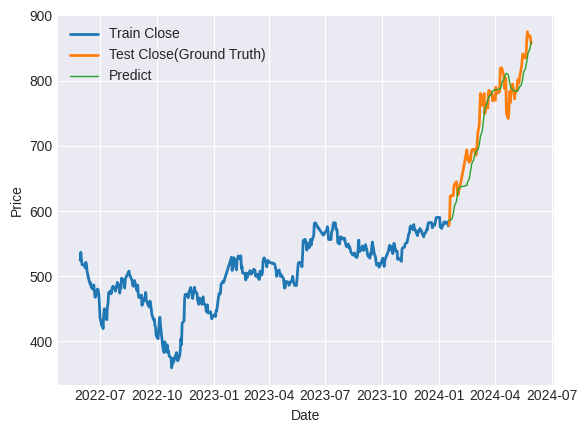

In [ ]:
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(train_df["Close"], linewidth=2)
plt.plot(test_df["Close"], linewidth=2)
plt.plot(test_df["Predict"], linewidth=1)
plt.legend(["Train Close", "Test Close(Ground Truth)", "Predict"])
plt.show()
# 藍線、橘線與綠線分別為訓練、測試、預測資料

選取片段放大呈現

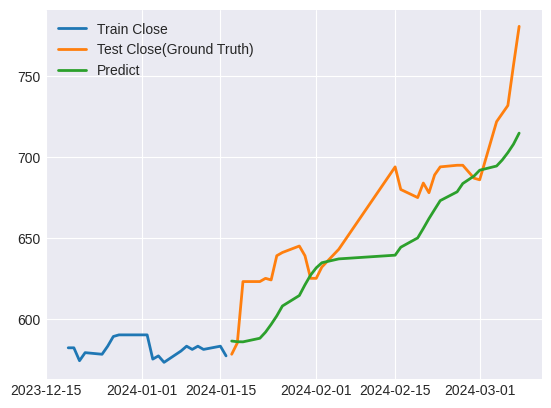

In [ ]:
plt.plot(train_df["Close"][-20:], linewidth=2)  # 取最後20筆訓練資料的收盤價
plt.plot(test_df["Close"][:30], linewidth=2)  # 取前30筆測試資料收盤價
plt.plot(test_df["Predict"][:30], linewidth=2)  # 取前30筆預測資料收盤價
plt.legend(["Train Close", "Test Close(Ground Truth)", "Predict"])
plt.show()

In [ ]:
# 加新列shifted: 顯示前一天收盤價
test_df = test_df.assign(Shifted = test_df["Close"].shift(1))
test_df.iat[0,-1] = train_df.iat[-1,-1]
test_df


,Close,Predict,Shifted
Date,,,
2024-01-17 00:00:00+08:00,578.299622,586.441711,577.304260
2024-01-18 00:00:00+08:00,585.267090,586.027344,578.299622
2024-01-19 00:00:00+08:00,623.090454,585.948425,585.267090
2024-01-22 00:00:00+08:00,623.090454,588.161621,623.090454
2024-01-23 00:00:00+08:00,625.081177,591.910217,623.090454
...,...,...,...
2024-05-23 00:00:00+08:00,875.000000,835.699768,864.000000
2024-05-24 00:00:00+08:00,867.000000,842.327820,875.000000
2024-05-27 00:00:00+08:00,869.000000,848.681030,867.000000


In [ ]:
# 計算Test data 的收盤價(GT)與Predict之間MSE
predict_rmse = mean_squared_error(test_df["Close"], test_df["Predict"], squared=False)
# 用百分比呈現，較方便解讀
predict_cvrmse = predict_rmse / test_df["Close"].mean() *100
print(f"預測價格MSE是測試價格MSE的{predict_cvrmse}倍")

預測價格MSE是測試價格MSE的3.400219478492253倍


In [ ]:
# 計算Test data 的收盤價(GT)與前一天收盤價之間MSE
shift_rmse = mean_squared_error(test_df["Close"], test_df["Shifted"], squared=False)
# 用百分比呈現，較方便解讀
shift_cvrmse = shift_rmse / test_df["Close"].mean() *100
print(f"前一天收盤價MSE是測試價格MSE的{shift_cvrmse}倍")

前一天收盤價MSE是測試價格MSE的2.022566019830295倍


# RNN

In [ ]:
model2 = Sequential([
    SimpleRNN(50, activation = 'tanh', return_sequences=True, input_shape=(train_x.shape[1],1)),  # 50個神經元,tanh激活函數,返回完整輸出序列,
    Dropout(0.2),  # 隨機丟棄0.2的神經元輸出
    SimpleRNN(50, activation= 'tanh', return_sequences=True),
    Dropout(0.2),
    SimpleRNN(50),
    Dropout(0.2),
    Dense(1)  # 全鏈接層，輸出一個值
])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 60, 50)            2600      
                                                                 
 dropout_3 (Dropout)         (None, 60, 50)            0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 60, 50)            5050      
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [ ]:
# compile
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
callback = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

model2.fit(
    train_x, train_y,
    validation_split = 0.2,
    callbacks = [callback],
    epochs = 1000
)

Epoch 1/1000
9/9 [==============================] - 7s 304ms/step - loss: 0.4381 - accuracy: 0.0037 - val_loss: 0.1581 - val_accuracy: 0.0000e+00
Epoch 2/1000
9/9 [==============================] - 1s 137ms/step - loss: 0.2249 - accuracy: 0.0000e+00 - val_loss: 0.0048 - val_accuracy: 0.0000e+00
Epoch 3/1000
9/9 [==============================] - 1s 144ms/step - loss: 0.2046 - accuracy: 0.0037 - val_loss: 0.0316 - val_accuracy: 0.0000e+00
Epoch 4/1000
9/9 [==============================] - 1s 145ms/step - loss: 0.1405 - accuracy: 0.0000e+00 - val_loss: 0.0263 - val_accuracy: 0.0000e+00
Epoch 5/1000
9/9 [==============================] - 1s 133ms/step - loss: 0.1226 - accuracy: 0.0037 - val_loss: 0.0297 - val_accuracy: 0.0000e+00
Epoch 6/1000
9/9 [==============================] - 1s 137ms/step - loss: 0.1194 - accuracy: 0.0037 - val_loss: 0.0033 - val_accuracy: 0.0000e+00
Epoch 7/1000
9/9 [==============================] - 1s 134ms/step - loss: 0.0854 - accuracy: 0.0037 - val_loss: 0.00

In [ ]:
train_df = df[:train_data_size+MOVING_WIN_SIZE]
test_df = df[train_data_size+MOVING_WIN_SIZE:]
test_df = test_df.assign(Predict=pred)
pred = model2.predict(test_x)
pred = scaler.inverse_transform(pred)

3/3 [==============================] - 0s 16ms/step


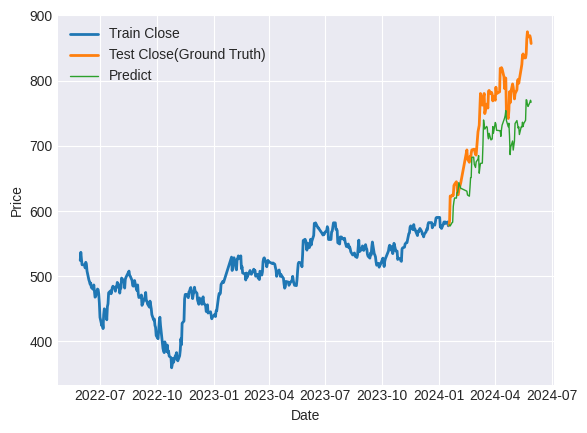

In [ ]:
# 繪圖觀察
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(train_df["Close"], linewidth=2)
plt.plot(test_df["Close"], linewidth=2)
plt.plot(test_df["Predict"], linewidth=1)
plt.legend(["Train Close", "Test Close(Ground Truth)", "Predict"])
plt.show()

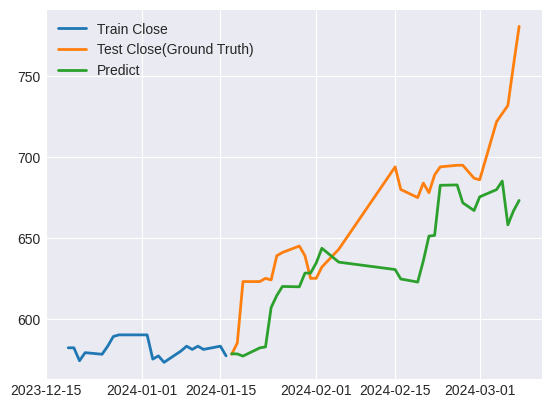

In [ ]:
# 放大觀察
plt.plot(train_df["Close"][-20:], linewidth=2)
plt.plot(test_df["Close"][:30], linewidth=2)
plt.plot(test_df["Predict"][:30], linewidth=2)
plt.legend(["Train Close", "Test Close(Ground Truth)", "Predict"])
plt.show()

In [ ]:
# 加入前一天收盤價
test_df = test_df.assign(Shifted = test_df["Close"].shift(1))
test_df.iat[0,-1] = train_df.iat[-1,-1]

# 計算Test data 的收盤價(GT)與Predict之間MSE
predict_rmse = mean_squared_error(test_df["Close"], test_df["Predict"], squared=False)
# 用百分比呈現，較方便解讀
predict_cvrmse = predict_rmse / test_df["Close"].mean() *100

print(f"預測價格MSE是測試價格MSE的{predict_cvrmse}倍")

預測價格MSE是測試價格MSE的8.549537372745315倍


In [ ]:
# 計算Test data 的收盤價(GT)與Predict之間MSE
shift_rmse = mean_squared_error(test_df["Close"], test_df["Shifted"], squared=False)
# 用百分比呈現，較方便解讀
shift_cvrmse = shift_rmse / test_df["Close"].mean() *100

print(f"前一天收盤價格MSE是測試價格MSE的{shift_cvrmse}倍")

前一天收盤價格MSE是測試價格MSE的2.022566019830295倍


# 結果比較呈現

## LSTM
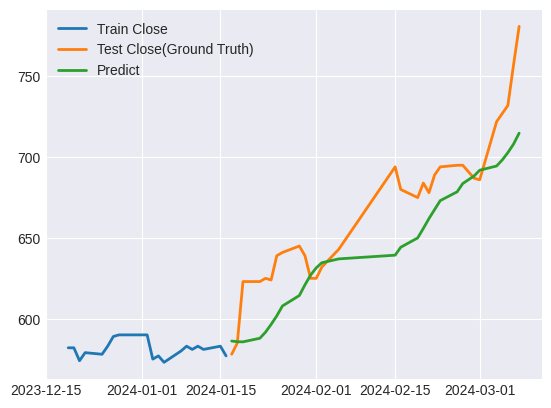

## RNN
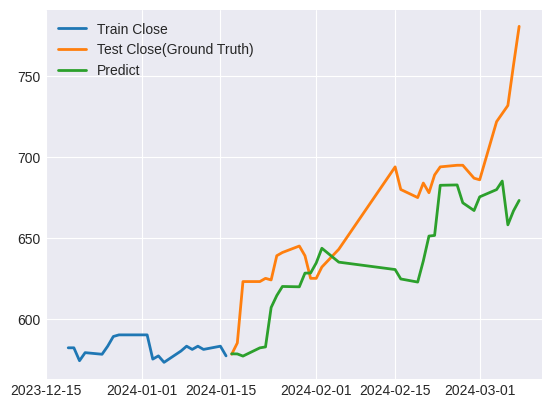